## Extract one OC with the DBSCAN parameters

In [13]:
using PyCall
using Statistics , StatsBase
using  DataFrames, Printf

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
plotdir = "$rootdir/products/testfull2"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering


cd(wdir)

In [14]:
function _get_OC(df , dfcart, labels , labelmax)
    ra= df.raw[1, labels[labelmax]]
    dec= df.raw[2,labels[labelmax]]
    l= df.data[1, labels[labelmax]]
    b= df.data[2,labels[labelmax]]
    d= df.data[3,labels[labelmax]]
    pmra= df.raw[6, labels[labelmax]]
    pmdec= df.raw[7, labels[labelmax]]
    X= dfcart.data[1, labels[labelmax]]
    Y= dfcart.data[2, labels[labelmax]]
    Z= dfcart.data[3, labels[labelmax]]
    vl= df.data[4,labels[labelmax]]
    vb= df.data[5,labels[labelmax]]
    vrad= df.raw[13,labels[labelmax]]
    gbar= df.raw[10,labels[labelmax]]
    rp= df.raw[11,labels[labelmax]]
    bp= df.raw[12,labels[labelmax]]
    ag= df.raw[14,labels[labelmax]]

    oc= DataFrame(ra=ra,dec=dec,l=l,b=b, distance=d,pmra=pmra, pmdec=pmdec, X=X,Y=Y,Z=Z,vl=vl,vb=vb,vrad=vrad,gbar=gbar,rp=rp,bp=bp, ag=ag)

    return(oc)
end

function _getdata(voname, wghtblck)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [15]:
## return the "best cluster"

function _find_cluster_label(labels, df::GaiaClustering.Df, dfcart::GaiaClustering.Df ,
    aperture2d = 1.5, maxaperture2d = 15, aperturev = 3.0, maxaperturev = 20, nboot = 30)
    
    ### metrics of the clusters
    q2d = metric2(dfcart, labels, "spatial2d" , aperture2d, maxaperture2d, nboot)
    q3d = metric2(dfcart, labels, "spatial3d" , aperture2d, maxaperture2d, nboot)     #### Added
    qv  = metric2(dfcart, labels, "velocity" , aperturev, maxaperturev, nboot)
    qp, qa = metric2(dfcart, labels, "HRD" )

    nlab = []
    for ilab in labels
        push!(nlab,length(ilab))
    end
    
    #### metric for the number of stars in the cluster
    qn = []
    for nl in nlab
        push!(qn,log10(nl))
    end
    
    qc= []
    for i in 1:length(nlab)
        k1 = q2d[i][1]
        k1bis = q3d[i][1]
        k2 = qv[i][1]
        k3 = qa[i][1]
        k4 = qn[i]
        ############### Composite metric ###
        qq = (2k1 + k1bis + 3k2 + k3 + k4) / 8.0
        # qq = (3k1 + k1bis + 3k2 + k4) / 8.0
        ###############
        push!(qc,qq)
    end
    
    println(qc)
    bestlabel= findmax(qc)[2]
    println("best label $bestlabel")
    
    return(bestlabel, nlab[bestlabel])
end

_find_cluster_label (generic function with 6 methods)

In [16]:
votname= "test.vot"

w3d=  4.1360939395973
wvel=   6.750049107155817
whrd=  2.61333343837

wght= [w3d, wvel, whrd]
df , dfcart , dfcartnorm = _getdata(votname, wght)

eps     =  4.268046182101999
min_cl  = 19
min_nei = 7


labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
labelbest, nstars= _find_cluster_label(labels, df, dfcart)
# labelmax , nmax = find_cluster_label(labels)

oc= _get_OC(df , dfcart, labels , labelbest)

## Votable test.vot read
## Filtering done ...
## Stars selected: 10995
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.32402682277993183, 0.32402682277993183, 0.32402682277993183, 0.5288073718202749, 0.5288073718202749, 0.204731841990521, 0.204731841990521, 0.204731841990521]
##
Any[0.8101761027984474, 0.6874954118853025, 0.7060961738119413, 0.7110812001035905, 0.6563395180925636, 0.3721888956515598, 1.2736800892403526, 0.9931825937903425, 0.24267165480203184, 0.39936993711834357, 0.6280069234895039, 0.739040153847745, 1.1300666407592193, 0.900475856137809, 0.7319075462340681, 0.7350854389249151, 0.514752559838394, 0.310341656954472, 0.7941612292371644, 0.8224412949325854]
best label 7


,ra,dec,l,b,distance,pmra,pmdec,X,Y
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,99.1681,4.97174,206.824,-1.00653,1516.93,-1.34625,0.759242,1516.82,16.7949
2,99.109,5.25157,206.549,-0.93027,1517.07,-0.963657,0.364966,1517.02,9.49868
3,99.2279,5.34986,206.516,-0.779958,1511.2,-1.22677,0.45956,1511.12,8.59337
4,99.1822,5.35884,206.487,-0.816231,1511.21,-1.14395,0.625475,1511.15,7.8323
5,98.9186,5.43981,206.294,-1.01206,1500.53,-1.08178,0.444164,1500.52,2.73476
6,99.0026,5.42866,206.343,-0.94295,1514.41,-1.39717,0.481142,1514.38,4.03783
7,98.809,5.35072,206.323,-1.14999,1491.05,-1.29816,1.09509,1491.04,3.46967
8,98.4688,5.25302,206.254,-1.49565,1496.84,-1.79034,1.15663,1496.83,1.6765
9,99.0827,5.58063,206.245,-0.802287,1517.1,-1.02279,0.287392,1517.05,1.44144


In [17]:
## plot_cluster

function _plot_oc(df)
    PyPlot.plt.figure(figsize=(13.0,12.0))

    PyPlot.plt.subplot(3, 3, 1 , xlim = [-20,20] , ylim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y), df.Z .- mean(df.Z) , s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 2 , ylim = [-20,20])
    PyPlot.plt.scatter(df.X, df.Z .- mean(df.Z)  , s = 1.0 )
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 4 , xlim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y) , df.X, s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 3 )
    PyPlot.plt.scatter(df.X, df.vrad , s = 1.0 )
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)    
        
    PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    text =[]
    txt = @sprintf("N stars: %3d",length(df.X)) ; push!(text,txt)
    txt = @sprintf("Distance: %3.1f (pc) +/- %3.1f",median(df.distance), std(df.distance)) ; push!(text,txt)
    txt = @sprintf("l: %3.3f (degree)",median(df.l)) ; push!(text,txt)
    txt = @sprintf("b: %3.3f (degree)",median(df.b)) ; push!(text,txt)  
    txt = @sprintf("Vl: %3.2f (km/s)",median(df.vl)) ; push!(text,txt) 
    txt = @sprintf("Vb: %3.2f (km/s)",median(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr: %3.2f (km/s, no masking)",median(df.vrad)) ; push!(text,txt)
    txt = @sprintf("X disp.: %3.2f (pc)", std(df.X)) ; push!(text,txt)
    txt = @sprintf("Y disp.: %3.2f (pc)", std(df.Y)) ; push!(text,txt)  
    txt = @sprintf("Z disp.: %3.2f (pc)", std(df.Z)) ; push!(text,txt)
    txt = @sprintf("Vl disp.: %3.2f (km/s) ", std(df.vl)) ; push!(text,txt)
    txt = @sprintf("Vb disp.: %3.2f (km/s)", std(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr disp.: %3.2f (km/s)", std(df.vrad)) ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")    
    PyPlot.plt.scatter(df.gbar-df.rp, -df.gbar , s = 1.0 )
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 8 )
    PyPlot.plt.scatter(df.vl, df.vb , s = 1.0 )
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)
end

_plot_oc (generic function with 1 method)

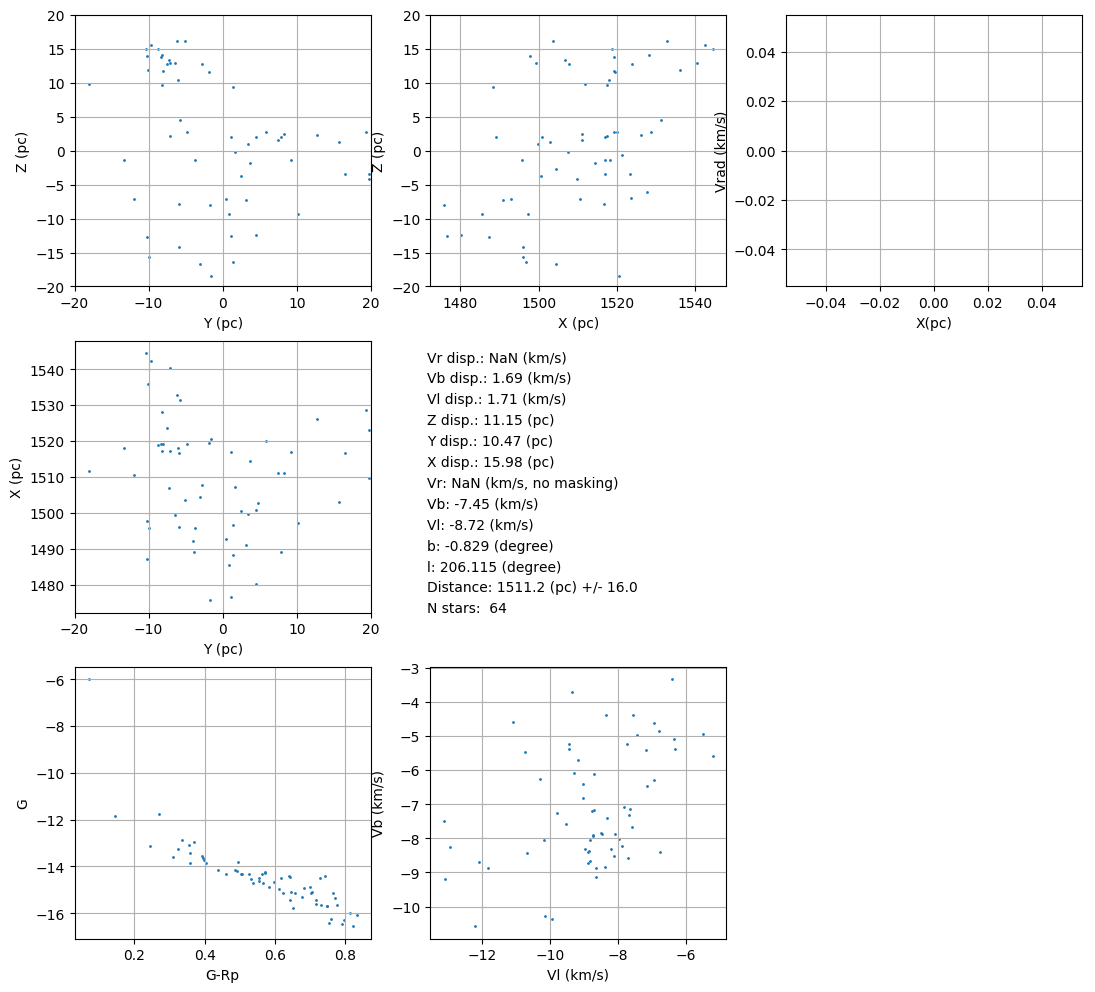

In [18]:
_plot_oc(oc)